In [1]:
import numpy
import os

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [4]:
from csv import DictReader, reader

In [5]:
import pp_util
import importlib
importlib.reload(pp_util)

<module 'pp_util' from '/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py'>

In [6]:
qual_colormap = plt.get_cmap("tab10")
plat_order=["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"]
csv_root="../data/"

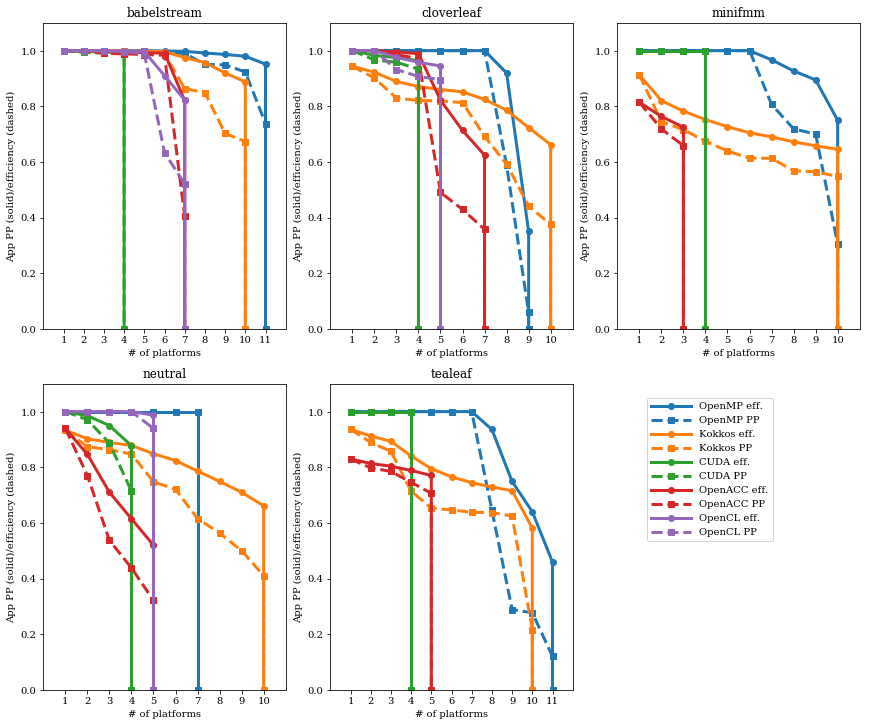

In [7]:
fig = plt.figure(figsize=(12, 10))
handles = {}
for i, appfile in enumerate(["babelstream.csv", "cloverleaf.csv", "minifmm.csv", "neutral.csv", "tealeaf.csv"]):
    ax = fig.add_subplot(2,3,i+1)
    throughput=(i==0)
    integrate=False
    appname=None
    pp_util.load_app_perfs(os.path.join(csv_root, appfile), throughput=throughput)
    min_plat = None
    max_plat = None
    appinfo = {}  
    for idx, name in enumerate(plat_order):
        if name not in pp_util.apps:
            continue
        data  = pp_util.apps[name]

        pps, effs = pp_util.pp_cdf(data, list(pp_util.platforms.keys()), throughput)

        ppl = list(reversed(pps))
        ppl =  ppl + [(ppl[-1][0], 0.0)]
        data_pp = numpy.asarray(ppl)
        effl = list(reversed(effs))
        effl =  effl + [(effl[-1][0], 0.0)]
        data_eff = numpy.asarray(effl)

        center = data_pp[:,0]

        lo = center-0.5
        hi = center+0.5
        if min_plat == None or center[0] < min_plat:
            min_plat = center[0]
        if max_plat == None or center[-1] > max_plat:
            max_plat = center[-1]

        appinfo[name] = (data, data_pp, data_eff, center)

    for name, (data, data_pp, data_eff, center) in appinfo.items():
        eff_name=f"{name} eff."
        pp_name=f"{name} PP"
        c = qual_colormap(plat_order.index(name))
        if integrate:
            tmp = numpy.zeros(data_pp.shape[0])
            tmp[0] = data_pp[0,1]
            for i in range(1, data_pp.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_pp[:i+1,1]) + tmp[0]
            data_pp[:,1] = tmp
            data_pp[-1,1] = data_pp[-2,1]
            data_pp[-1,0] = max_plat

            tmp[0] = data_eff[0,1]
            for i in range(1, data_eff.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_eff[:i+1,1]) + tmp[0]
            data_eff[:,1] = tmp
            data_eff[-1,1] = data_eff[-2,1]
            data_eff[-1,0] = max_plat
            mycenter = center[:]
            mycenter[data_pp.shape[0]-1] = max_plat

            eff_h = ax.plot(mycenter,data_pp[:,1], label=eff_name, color=c, marker="o",lw=3)
            pp_h = ax.plot(mycenter,data_eff[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')
        else:
            eff_h = ax.plot(center,data_pp[:,1], label=eff_name, color=c, marker="o",lw=3)
            pp_h = ax.plot(center,data_eff[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')
              
        if eff_name not in handles:
            handles[eff_name] = eff_h
        if pp_name not in handles:
            handles[pp_name] = pp_h
            
    if appname == None:
        appname = os.path.splitext(os.path.basename(appfile))[0]
    if integrate:
        ax.set_title(f"Cumulative {appname} pp/efficiency over # of platforms")
        ax.set_ylabel("Cumulative App PP (solid)/efficiency (dashed)")
    else:
        ax.set_title(f"{appname}")
        ax.set_ylabel("App PP (solid)/efficiency (dashed)")
    ax.set_xlabel("# of platforms")
    ax.set_xlim([0,max_plat+1])
    if not integrate:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0,max_plat+1])
    ax.set_xticks(numpy.arange(min_plat, max_plat+1))
fig.legend(handles, loc='lower right', bbox_to_anchor=(0.90,0.25),handlelength=4.0)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    
plt.savefig(f"../../images/app_platforms_cliff.pdf", bbox_inches="tight")

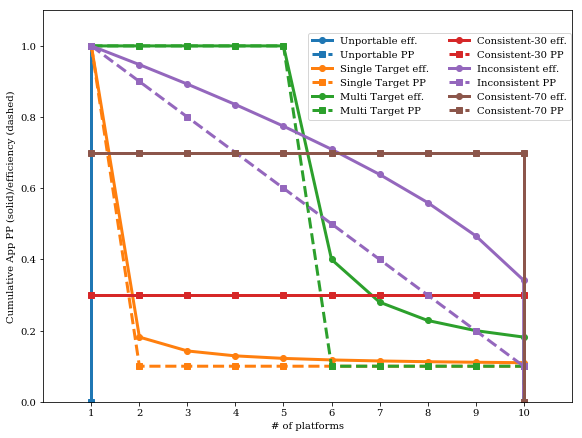

In [8]:
fig = plt.figure(figsize=(8, 6))
handles = {}
for i, appfile in enumerate(["metrics_data_synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    app_eff = pp_util.read_effs(os.path.join(csv_root, appfile))
    integrate=False
    appname=None
    min_plat = None
    max_plat = None
    appinfo = {}  
    for i, (name, in_effs) in enumerate(app_eff):
        pps, effs = pp_util.pp_cdf_raw_effs(in_effs)

        ppl = list(reversed(pps))
        ppl =  ppl + [(ppl[-1][0], 0.0)]
        data_pp = numpy.asarray(ppl)
        effl = list(reversed(effs))
        effl =  effl + [(effl[-1][0], 0.0)]
        data_eff = numpy.asarray(effl)

        center = data_pp[:,0]

        lo = center-0.5
        hi = center+0.5
        if min_plat == None or center[0] < min_plat:
            min_plat = center[0]
        if max_plat == None or center[-1] > max_plat:
            max_plat = center[-1]

        appinfo[name] = (data, data_pp, data_eff, center, i)
        
    for name, (data, data_pp, data_eff, center, index) in appinfo.items():
        eff_name=f"{name} eff."
        pp_name=f"{name} PP"
        c = qual_colormap(index)
        if integrate:
            tmp = numpy.zeros(data_pp.shape[0])
            tmp[0] = data_pp[0,1]
            for i in range(1, data_pp.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_pp[:i+1,1]) + tmp[0]
            data_pp[:,1] = tmp
            data_pp[-1,1] = data_pp[-2,1]
            data_pp[-1,0] = max_plat

            tmp[0] = data_eff[0,1]
            for i in range(1, data_eff.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_eff[:i+1,1]) + tmp[0]
            data_eff[:,1] = tmp
            data_eff[-1,1] = data_eff[-2,1]
            data_eff[-1,0] = max_plat
            mycenter = center[:]
            mycenter[data_pp.shape[0]-1] = max_plat

            eff_h = ax.plot(mycenter,data_pp[:,1], label=eff_name, color=c, marker="o",lw=3)
            pp_h = ax.plot(mycenter,data_eff[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')
        else:
            eff_h = ax.plot(center,data_pp[:,1], label=eff_name, color=c, marker="o",lw=3)
            pp_h = ax.plot(center,data_eff[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')
              
        if eff_name not in handles:
            handles[eff_name] = eff_h
        if pp_name not in handles:
            handles[pp_name] = pp_h
            
    if appname == None:
        appname = os.path.splitext(os.path.basename(appfile))[0]
        #ax.set_title(f"Cumulative {} pp/efficiency over # of platforms")
        ax.set_ylabel("Cumulative App PP (solid)/efficiency (dashed)")
    else:
        #ax.set_title(f"{appname}")
        ax.set_ylabel("App PP (solid)/efficiency (dashed)")
    ax.set_xlabel("# of platforms")
    ax.set_xlim([0,max_plat+1])
    if not integrate:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0,max_plat+1])
    ax.set_xticks(numpy.arange(min_plat, max_plat+1))
fig.legend(handles, loc='upper right',bbox_to_anchor=(1.0, 0.95), handlelength=2.0, ncol=2)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    
plt.savefig(f"../../images/synthetic_cliff.pdf", bbox_inches="tight")